In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
#import sys
#sys.path.append('../src/modules') #Только так сработало!
from functions import prepare_data, encode_features, get_tree_based_predicts

At first let's perform some EDA and DQC

In [3]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
holidays_events_data = pd.read_csv('../data/holidays_events.csv')
oil_data = pd.read_csv('../data/oil.csv')
stores_data = pd.read_csv('../data/stores.csv')
transactions_data = pd.read_csv('../data/transactions.csv')

In [4]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
train_data.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [6]:
test_data.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [7]:
train_data.duplicated().sum()

0

In [8]:
train_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [10]:
len(train_data)

3000888

In [11]:
len(test_data)

28512

In [12]:
train_data.duplicated().sum()

0

In [13]:
holidays_events_data.duplicated().sum()

0

In [14]:
oil_data.duplicated().sum()

0

In [15]:
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [16]:
holidays_events_data['priority'] = holidays_events_data['locale'].map({'National': 3, 'Regional': 2, 'Local': 1})
holidays_events_data = holidays_events_data.sort_values(by=['date', 'priority'], ascending=False)
holidays_events_data = holidays_events_data.drop_duplicates(subset=['date'], keep='first')
holidays_events_data.drop('priority', axis=1, inplace=True)

In [17]:
holidays_events_data[pd.to_datetime(holidays_events_data['date']) == pd.to_datetime('2013-06-25')]

,date,type,locale,locale_name,description,transferred
58,2013-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False


In [21]:
"""def prepare_data(data):
    #data = pd.merge(data, transactions_data, on=['date', 'store_nbr'], how='inner')  !Some questions about this dataset appeared
    data = pd.merge(data, stores_data, on=['store_nbr'], how='inner')
    data = pd.merge(data, oil_data, on=['date'], how='left')
    data = pd.merge(data, holidays_events_data, on=['date'], how='left')   # Длина train_data увеличилась что странно, надо смотреть почему
    
    data.fillna({'type_y': 'Not holiday', 'locale': 'Not holiday', 'locale_name' : 'Not holiday', 'description' : 'Not holiday',
                         'transferred' : 'Not holiday'}, inplace=True)

    data.rename(columns={'store_nbr' : 'store_number', 'type_x': 'store_type', 'cluster' : 'store_cluster',
                        'dcoilwtico' : 'oil_price', 'locale' : 'holiday_status', 'locale_name' : 'holiday_location',
                        'description' : 'holiday_description', 'type_y' : 'day_type', 'transferred' : 'is_holiday_transferred',
                        'family' : 'item_family', 'sales' : 'item_sales', 'onpromotion' : 'items_on_promotion'}, inplace=True)
    data['date'] = pd.to_datetime(data['date'])  
    data.set_index('id', inplace=True)
    data['oil_price'].bfill(inplace=True)
    data['is_holiday_transferred'] = data['is_holiday_transferred'].map(lambda x: False if x == False or x == 'Not holiday' else True)
    return data
"""


"def prepare_data(data):\n    #data = pd.merge(data, transactions_data, on=['date', 'store_nbr'], how='inner')  !Some questions about this dataset appeared\n    data = pd.merge(data, stores_data, on=['store_nbr'], how='inner')\n    data = pd.merge(data, oil_data, on=['date'], how='left')\n    data = pd.merge(data, holidays_events_data, on=['date'], how='left')   # Длина train_data увеличилась что странно, надо смотреть почему\n    \n    data.fillna({'type_y': 'Not holiday', 'locale': 'Not holiday', 'locale_name' : 'Not holiday', 'description' : 'Not holiday',\n                         'transferred' : 'Not holiday'}, inplace=True)\n\n    data.rename(columns={'store_nbr' : 'store_number', 'type_x': 'store_type', 'cluster' : 'store_cluster',\n                        'dcoilwtico' : 'oil_price', 'locale' : 'holiday_status', 'locale_name' : 'holiday_location',\n                        'description' : 'holiday_description', 'type_y' : 'day_type', 'transferred' : 'is_holiday_transferred',\n   

In [18]:
train_data = prepare_data(train_data)
test_data = prepare_data(test_data)

NameError: name 'prepare_data' is not defined

In [23]:
train_data.head()

,date,store_number,item_family,item_sales,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [24]:
test_data.head()

,date,store_number,item_family,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False


In [25]:
train_data.isna().sum()

date                      0
store_number              0
item_family               0
item_sales                0
items_on_promotion        0
city                      0
state                     0
store_type                0
store_cluster             0
oil_price                 0
day_type                  0
holiday_status            0
holiday_location          0
holiday_description       0
is_holiday_transferred    0
dtype: int64

In [26]:
test_data.isna().sum()

date                      0
store_number              0
item_family               0
items_on_promotion        0
city                      0
state                     0
store_type                0
store_cluster             0
oil_price                 0
day_type                  0
holiday_status            0
holiday_location          0
holiday_description       0
is_holiday_transferred    0
dtype: int64

In [27]:
len(train_data)

3054348

In [28]:
len(test_data)

28512

So we see that the lengths of the datasets are same as they were before the preprocessing

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3054348 entries, 0 to 3000887
Data columns (total 15 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date                    datetime64[ns]
 1   store_number            int64         
 2   item_family             object        
 3   item_sales              float64       
 4   items_on_promotion      int64         
 5   city                    object        
 6   state                   object        
 7   store_type              object        
 8   store_cluster           int64         
 9   oil_price               float64       
 10  day_type                object        
 11  holiday_status          object        
 12  holiday_location        object        
 13  holiday_description     object        
 14  is_holiday_transferred  bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 352.5+ MB


In [30]:
train_data[train_data['item_sales'] != 0]['item_family'].value_counts()

item_family
BREAD/BAKERY                  85125
BEVERAGES                     85124
MEATS                         85124
CLEANING                      85124
DAIRY                         85124
DELI                          85124
EGGS                          85124
GROCERY I                     85122
PERSONAL CARE                 85119
POULTRY                       85111
PREPARED FOODS                85104
FROZEN FOODS                  85097
GROCERY II                    81367
AUTOMOTIVE                    80766
LINGERIE                      77723
LIQUOR,WINE,BEER              76005
SEAFOOD                       74667
BEAUTY                        68261
PRODUCE                       66469
HOME AND KITCHEN I            60573
HOME AND KITCHEN II           60508
HOME CARE                     54877
CELEBRATION                   52375
PLAYERS AND ELECTRONICS       51230
LAWN AND GARDEN               49287
HARDWARE                      48290
PET SUPPLIES                  42183
MAGAZINES       

In [31]:
len(train_data['item_family'].unique())

33

In [32]:
train_data['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [33]:
train_data['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [34]:
sorted(train_data['store_number'].unique())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54]

In [35]:
train_data['store_type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [36]:
sorted(train_data['store_cluster'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [37]:
train_data['day_type'].unique()

array(['Holiday', 'Not holiday', 'Work Day', 'Additional', 'Event',
       'Transfer', 'Bridge'], dtype=object)

In [38]:
train_data['day_type'].value_counts()

day_type
Not holiday    2551824
Holiday         304722
Event            99792
Additional       67716
Transfer         16038
Work Day          8910
Bridge            5346
Name: count, dtype: int64

In [39]:
train_data['holiday_status'].unique()

array(['National', 'Not holiday', 'Local', 'Regional'], dtype=object)

In [40]:
train_data['holiday_location'].unique()

array(['Ecuador', 'Not holiday', 'Manta', 'Cotopaxi', 'Cuenca',
       'Libertad', 'Riobamba', 'Puyo', 'Guaranda', 'Imbabura', 'Machala',
       'Latacunga', 'El Carmen', 'Santo Domingo', 'Cayambe', 'Guayaquil',
       'Esmeraldas', 'Ambato', 'Ibarra', 'Quevedo',
       'Santo Domingo de los Tsachilas', 'Santa Elena', 'Quito', 'Loja',
       'Salinas'], dtype=object)

In [41]:
len(train_data['holiday_description'].unique())

102

In [42]:
train_data['item_sales'].min()

0.0

In [43]:
train_data['item_sales'].max()

124717.0

In [44]:
train_data['item_sales'].mean()

359.02089225139053

In [45]:
train_data['item_sales'].median()

11.0

In [46]:
train_data[train_data['item_sales'] == train_data['item_sales'].max()]

,date,store_number,item_family,item_sales,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,,
2163723,2016-05-02,2,GROCERY I,124717.0,59,Quito,Pichincha,D,13,44.75,Event,National,Ecuador,Terremoto Manabi+16,False


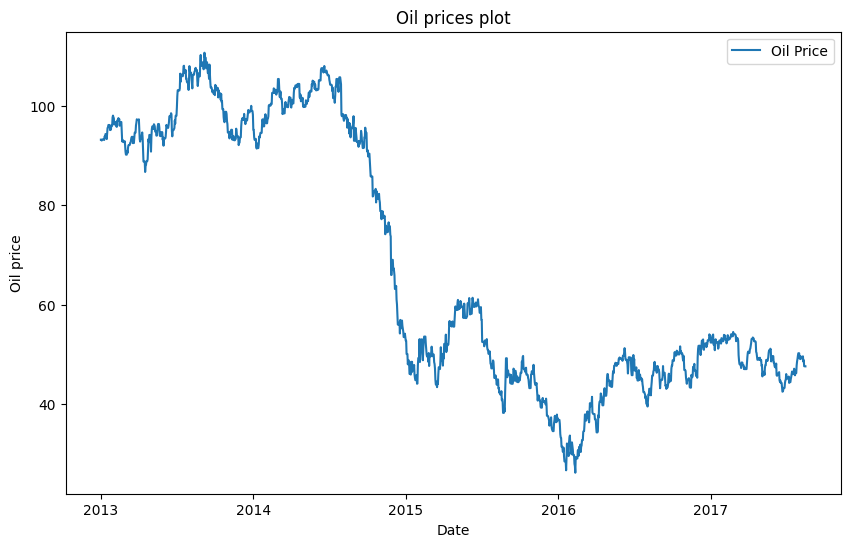

In [47]:
plt.figure(figsize=(10, 6))  
plt.plot(train_data['date'], train_data['oil_price'], label='Oil Price')
plt.title('Oil prices plot')
plt.xlabel('Date')
plt.ylabel('Oil price')
plt.legend()
plt.show()

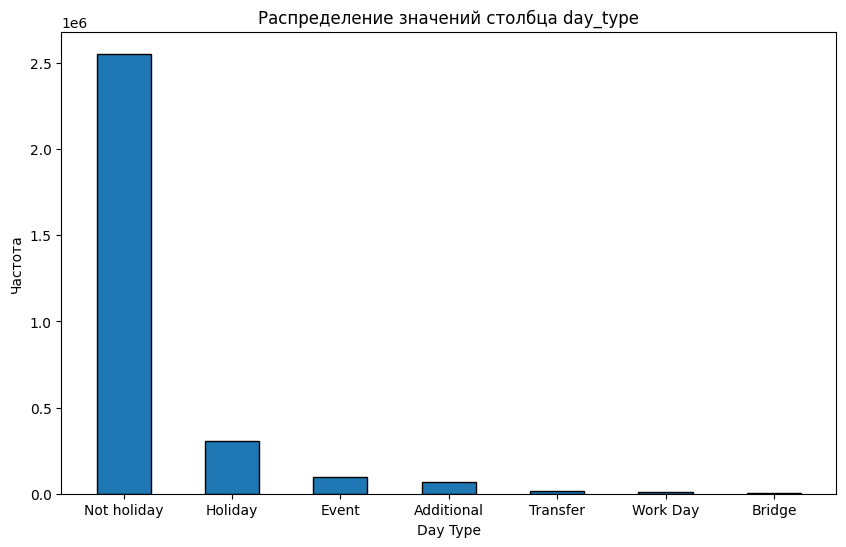

In [48]:
plt.figure(figsize=(10, 6))  
plt.bar(train_data['day_type'].value_counts().index, train_data['day_type'].value_counts(), width=0.5, edgecolor='black')
plt.title('Распределение значений столбца day_type')
plt.xlabel('Day Type')
plt.ylabel('Частота')
plt.show()

In [49]:
train_data.head()

,date,store_number,item_family,item_sales,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,93.14,Holiday,National,Ecuador,Primer dia del ano,False


In [50]:
test_data.head()

,date,store_number,item_family,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False
3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8,Not holiday,Not holiday,Not holiday,Not holiday,False


In [52]:
train_data, test_data = encode_features(train_data, test_data)

In [53]:
train_data

,days_since_start,store_number,item_family,item_sales,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,,
0,0,1,0,0.000,0,18,12,3,13,93.14,3,1,4,51,0
1,0,1,1,0.000,0,18,12,3,13,93.14,3,1,4,51,0
2,0,1,2,0.000,0,18,12,3,13,93.14,3,1,4,51,0
3,0,1,3,0.000,0,18,12,3,13,93.14,3,1,4,51,0
4,0,1,4,0.000,0,18,12,3,13,93.14,3,1,4,51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,1687,9,28,438.133,0,18,12,1,6,47.57,3,0,20,28,0
3000884,1687,9,29,154.553,1,18,12,1,6,47.57,3,0,20,28,0
3000885,1687,9,30,2419.729,148,18,12,1,6,47.57,3,0,20,28,0


In [54]:
test_data.head()

,days_since_start,store_number,item_family,items_on_promotion,city,state,store_type,store_cluster,oil_price,day_type,holiday_status,holiday_location,holiday_description,is_holiday_transferred
id,,,,,,,,,,,,,,
3000888,1688,1,0,0,18,12,3,13,46.8,4,2,16,49,0
3000889,1688,1,1,0,18,12,3,13,46.8,4,2,16,49,0
3000890,1688,1,2,2,18,12,3,13,46.8,4,2,16,49,0
3000891,1688,1,3,20,18,12,3,13,46.8,4,2,16,49,0
3000892,1688,1,4,0,18,12,3,13,46.8,4,2,16,49,0


In [55]:
len(train_data['days_since_start'].unique()) * len(train_data['store_number'].unique()) * len(train_data['item_family'].unique())

3000888

So we see that the dataset consists of all unique threes(day-store-item). Now let's split it into many different time-series and predict separately for each of them

In [57]:
#Train test split explicit shecking needed

In [58]:
xgboost = xgb.XGBRegressor(max_depth=2, n_jobs=-1, random_state=42)
models = [xgboost]
models_names = ['XGBoost']

all_sales = pd.DataFrame()
mae_scores = []
mape_scores = []

for store_num in train_data['store_number'].unique():
    for item_family in train_data['item_family'].unique():
        data = train_data[(train_data['store_number'] == store_num) & (train_data['item_family'] == item_family)]

        X = data.drop(['item_sales'], axis=1)
        y = data['item_sales']
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)
        predicts = get_tree_based_predicts(X_train, X_valid, y_train, y_valid, models, models_names)

        df = predicts[0]
        mae = predicts[1][0]
        mape = predicts[2][0]

        all_sales = pd.concat([all_sales, df], axis=0)

        mae_scores.append(mae)
        mape_scores.append(mape)

print('Average MAE for XGBoost:', np.array(mae_scores).mean())
print('Average MAPE in % for XGBoost:', np.array(mape_scores).mean())

Average MAE for XGBoost: 132.3466049382716
Average MAPE in % for XGBoost: 3.564161871736987e+17


In [59]:
train_data['item_sales'].mean()

359.02089225139053

In [60]:
all_sales.sort_index().tail(30)[['Real Sales', 'XGBoost']]

,Real Sales,XGBoost
id,,
3000858,3530.000,3736.874512
3000859,0.000,0.000000
3000860,528.000,570.310608
3000861,16.000,15.506574
3000862,1439.000,2227.504883
3000863,835.000,1120.577271
3000864,551.713,657.936646
3000865,244.000,180.246414
3000866,133.738,107.262650
